# 深度残差网络的代码实现
深度残差网络是中微软kaiming he等提出的，在ILSVRC 2015中的classification，detection，localization任务取得了冠军，且在COCO比赛上也夺冠【[论文](https://arxiv.org/abs/1512.03385)】。在这里对深度残差网络使用keras实现，这里使用的数据集是notmnist，字母A-J，十个字母的识别。(数据集小，渣渣笔记本上运行)
## 1. 读取数据

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tqdm

complete!


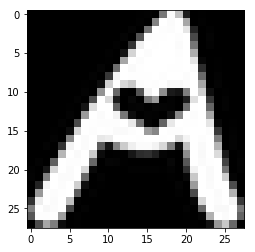

In [3]:
train_path='../datasets/notmnist/notMNIST_large/'
test_path='../datasets/notmnist/notMNIST_small/'
img_size=28
num_channels=3

# 读取文件夹图像
def read_letters(folder, size=None):
    image_names=os.listdir(folder,)
    images=[]
    for index, img_name in enumerate(image_names):
        if size and index>size-1: break
        image=cv2.imread(folder+img_name)
        if not image is None: 
            images.append(image)
    return np.array(images)

A=read_letters(train_path+'A/', 100)
print('complete!')
plt.imshow(A[66])
plt.show()

In [4]:
def concate(x, x_):
    if not x is None: 
        x=np.concatenate([x, x_], axis=0)
    else: x=x_
    return x

def get_data(train_size=None, test_size=None):
    letters=['A', 'B','C','D','E','F','G','H','I','J']
    x_train=y_train=x_test=y_test=None
    for index, letter in tqdm.tqdm(enumerate(letters)):
        x_=read_letters(train_path+letter+'/', train_size)
        x_train=concate(x_train, x_)
        y_=np.ndarray([x_.shape[0]], dtype=np.uint8)
        y_[:]=index
        y_train=concate(y_train, y_) 
        x_=read_letters(test_path+letter+'/', test_size)
        x_test=concate(x_test, x_)
        y_=np.ndarray([x_.shape[0]], dtype=np.uint8)
        y_[:]=index
        y_test=concate(y_test, y_)
    return x_train, y_train, x_test, y_test
    
'''for train fast, here i use 1000 training samples per category and 200 test samples'''
x_train, y_train, x_test, y_test = get_data(1000, 200)

print(x_train.shape,y_train.shape)

#from sklearn.model_selection import train_test_split
#train_test_split()

10it [01:26,  8.63s/it]


(10000, 28, 28, 3) (10000,)


In [5]:
# pre process
import keras

y_train=keras.utils.to_categorical(y_train, num_classes=10)
y_test=keras.utils.to_categorical(y_test, num_classes=10)

Using TensorFlow backend.


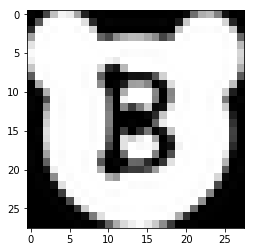

[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


In [23]:
perm=np.random.permutation(x_train.shape[0])
x_train=x_train[perm]
y_train=y_train[perm]

plt.imshow(x_train[8])
plt.show()
print(y_train[8])

## 2. 建立一个简单模型测试

In [24]:
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Input, AveragePooling2D, Add
from keras.optimizers import Adam, rmsprop
from keras.callbacks import EarlyStopping

In [26]:
conv_model=Sequential()
conv_model.add(Conv2D(8, (3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=(img_size, img_size, num_channels)))
conv_model.add(Conv2D(16, (3, 3), strides=(1, 1), padding='same', activation='relu'))
conv_model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu'))
conv_model.add(MaxPooling2D(pool_size=2))
conv_model.add(Flatten())
conv_model.add(Dense(100, activation='relu'))
conv_model.add(Dense(10, activation='softmax'))

conv_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopper=EarlyStopping(patience=30)
conv_model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=1000, epochs=10, verbose=2, shuffle=True, 
              callbacks=[early_stopper])

## 3. 深度卷积网络实现
A building block:
![residual](./images/20180213180857.png)
我们的目标是构建这样的块，一共有两种，一种恒等映射，x; 一种非恒等，就是输入和输出的维度不一样，需要对输入进行变换wx。 （**identity & projection** shortcut） 
### (1) identity shorcut
层顺序：conv2d -> BN -> relu，可以是任意层，注意最后一个层要残差链接后再激活函数relu输出

In [27]:
# x：输入，filters：卷积核数，kernelsize：核大小
def identity_shortcut(x, filters, kernel_sizes):
    last=x
    for i, f in enumerate(filters):
        last=Conv2D(f, kernel_sizes[i], strides=(1, 1), padding='same')(last)
        last=BatchNormalization()(last)
        if i<len(filters)-1: last=Activation('relu')(last)
    #return Activation('relu')(x+last)
    return Activation('relu')(Add()([x, last]))

### (2) projection shortcut
与identity shortcut不一样的有两点：
- projection中的第一层可能需要做downsampling，即stride为2
- 最后一层残差连接，因为维度不一样，要对输入做投射到相同维度；因为经过第一层的downsampling，feature map 边大小减半。所以连接时对x(输入)做卷积操作，步数为2，核大小1,核数等于最后一层核数。 

(**详细在代码或论文中展示** 

In [28]:
def projection_shortcut(x, filters, kernel_sizes, strides=(2, 2), proj_strides=(2, 2)):
    last=x
    for i, f in enumerate(filters):
        if i==0: last=Conv2D(f, kernel_sizes[i], strides=strides, padding='same')(last)
        else: last=Conv2D(f, kernel_sizes[i], strides=(1, 1), padding='same')(last)
        last=BatchNormalization()(last)
        if i<len(filters)-1: last=Activation('relu')(last)
    x= Conv2D(filters[-1], (1, 1), strides=proj_strides)(x)
    x=BatchNormalization()(x)
    return Activation('relu')(Add()([x, last]))

ps: 这里犯了个错误，因为对keras算刚接触不久，后面的model代码报错：*'Tensor' object has no attribute '_keras_history'* ，最后发现是+法的错，在keras中不能直接相加，应该是keras中应该需要记录(\_keras_history), 所以不支持直接相加，减法，乘法等)
https://stackoverflow.com/questions/45030966/attributeerrortensor-object-has-no-attribute-keras-history 中：

> The problem lied in the fact that using every tf operation should be encapsulated by either:
> 1. Using keras.backend functions,
> 2. Lambda layers,
> 3. Designated keras functions with the same behavior.

> When you are using tf operation - you are getting tf tensor object which doesn't have history field. When you use keras functions you will get keras.tensors.

所以是因为+操作返回了tensorflow的tensor，从而没有history field。

### (3) model details
论文中网络有5个，分别为18，34，50，101和152层，具体如下表(表中后三个网络的第一个卷积层核数为256)：
![networks](./images/20180213225351.png)
有了两个函数后就只需跟着表建立即可，用到projection shortcut的是conv3_1, conv4_1, conv5_1。
下面将实现50-layer：

In [29]:
inp=Input(shape=(img_size, img_size, num_channels))

# out=Flatten()(inp)
# print(out.shape)
# model=Model(inputs=inp, outputs=out)

out=Conv2D(256, 7, strides=2, padding='same')(inp)
print(out.shape)
out=BatchNormalization()(out)
out=Activation('relu')(out)
out=MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(out)
print(out.shape)

out=identity_shortcut(out, [64, 64, 256], [1, 3, 1])
out=identity_shortcut(out, [64, 64, 256], [1, 3, 1])
out=identity_shortcut(out, [64, 64, 256], [1, 3, 1])

out=projection_shortcut(out, [128, 128, 512], [1, 3, 1])
out=identity_shortcut(out, [128, 128, 512], [1, 3, 1])
out=identity_shortcut(out, [128, 128, 512], [1, 3, 1])
out=identity_shortcut(out, [128, 128, 512], [1, 3, 1])

out=projection_shortcut(out, [256, 256, 1024], [1, 3, 1])
out=identity_shortcut(out, [256, 256, 1024], [1, 3, 1])
out=identity_shortcut(out, [256, 256, 1024], [1, 3, 1])
out=identity_shortcut(out, [256, 256, 1024], [1, 3, 1])
out=identity_shortcut(out, [256, 256, 1024], [1, 3, 1])
out=identity_shortcut(out, [256, 256, 1024], [1, 3, 1])

out=projection_shortcut(out, [512, 512, 2048], [1, 3, 1])
out=identity_shortcut(out, [512, 512, 2048], [1, 3, 1])
out=identity_shortcut(out, [512, 512, 2048], [1, 3, 1])

out=AveragePooling2D(padding='same')(out)
out=Flatten()(out)
print(out.shape)
out=Dense(10, activation='softmax')(out)
model=Model(inputs=inp, outputs=out)

(?, 14, 14, 256)
(?, 7, 7, 256)
(?, ?)


In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopper=EarlyStopping(patience=10)
model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=1000, epochs=100, verbose=2, shuffle=True, 
               callbacks=[early_stopper])

Train on 10000 samples, validate on 2000 samples
Epoch 1/100
 - 1561s - loss: 3.4706 - acc: 0.1152 - val_loss: 4.4505 - val_acc: 0.1410
Epoch 2/100


***
至此，深度卷积神经网络的框架就实现了，不过论文中的数据增强，crops，ensemble等就没有去做实现。